<a href="https://colab.research.google.com/github/granatb/02456-deep-learning-with-PyTorch/blob/master/pipeline_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 
from torch.utils.data import TensorDataset, DataLoader

sns.set_style("whitegrid")
%matplotlib inline

In [2]:
def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000
    # display.precision = 2  # set as needed

set_pandas_display_options()

In [3]:
def Lag_N(series, N):
    return series.shift(N)

def Lag_diff(series, N):
    return series.diff(periods = N)

def Lag_ratio(series, N):
    return series/series.shift(N)

def AVG_N(series, N):
    ret = [0]*len(series)
    for i in range(N,len(series)):
        ret[i] = np.mean(series[i-N:i])
    return ret

def Min_N(series, N):
    ret = [0]*len(series)
    for i in range(N, len(series)):
        ret[i] = np.min(series[i-N:i])
    return ret

def Max_N(series, N):
    ret = [0]*len(series)
    for i in range(N, len(series)):
        ret[i] = np.max(series[i-N:i])
    return ret

def Avg_shift(series, rng):
    ret = [0]*len(series)
    for i in range(rng[1], len(series)):
        ret[i] = np.mean(series[i-rng[1]:i-rng[0]+1])
    return ret
def SD_N(series, N):
    ret = [0] * len(series)
    for i in range(N, len(series)):
        ret[i] = np.std(series[i - N:i])
    return ret

def EMA_N(series, N):
    ret = pd.Series.ewm(series, span = N, adjust = False).mean()
    return ret

def MACD(series, args):
    ema_1 = pd.Series.ewm(series, span = args[0], adjust = False).mean()
    ema_2 = pd.Series.ewm(series, span = args[1], adjust = False).mean()
    ema_signal = pd.Series.ewm(series, span = args[2], adjust = False).mean()
    ret = ema_1-ema_2-ema_signal
    return ret

def SO_N(series, N):
    ret = [0] * len(series)
    for i in range(N, len(series)):
        L_N = np.min(series[i-N:i])
        H_N = np.max(series[i-N:i])
        ret[i] = 100*(series[i-1]-L_N)/(H_N-L_N)
    return ret
    
def RSI_N(series, N):
    delta = series.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    avg_gain = [0] * len(series)
    avg_loss = [0] * len(series)
    avg_gain[N+1] = pd.Series(up[1:N+1]).mean()
    avg_loss[N+1] = pd.Series(down[1:N+1]).mean()
    for i in range(N+2, len(series)):
        avg_gain[i] = ((N-1)*avg_gain[i-1]+up[i-1])/N
        avg_loss[i] = ((N-1) * avg_loss[i-1]+down[i-1]) / N

    RS = pd.Series(avg_gain) / ((-1) * pd.Series(avg_loss))
    RSI = 100.0 - (100.0 / (1.0 + RS))

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
datasets_path = "/content/drive/My Drive/data/Datasets/"

In [6]:
df = pd.read_csv(datasets_path+'Case1/Proj_NWP_Case1.csv')
df.Date_Time = pd.to_datetime(df.Date_Time)

In [7]:
dfm = pd.read_csv(datasets_path+'Case1/Proj_Measurements_Case1.csv')
dfm.Date_Time = pd.to_datetime(dfm.Date_Time)

In [25]:
# df_full = dfm.add_suffix('_m').join(df.add_suffix('_nwp'))
df_full = dfm.merge(df, on = "Date_Time", suffixes=('_m', '_nwp'))
df_full['Month'] = pd.DatetimeIndex(df_full.Date_Time).month
df_full['Year'] = pd.DatetimeIndex(df_full.Date_Time).year
df_full['Day'] = pd.DatetimeIndex(df_full.Date_Time).day
df_full.head(3)

,Date_Time,Speed_10m_m,Direction_10m_m,Speed_30m,Direction_30m,Speed_65m,Direction_65m,Speed_70m,Direction_70m,Speed_80m,Direction_80m,Park Power [KW],Direction_10m_nwp,Speed_10m_nwp,Temperature_10m,Pressure_seaLevel,Air Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air Density_150m,Month,Year,Day
0,2017-01-07 20:15:00,2.950,96.4,1.800,89.6,3.300,200.0,3.400,187.1,0.0,0.0,NaN,171,1.43,-16.91,1005.28,1.367,170,1.53,-16.91,1.367,174,1.04,-16.91,1.367,185,0.65,-16.91,1.367,1,2017,7
1,2017-01-07 20:30:00,2.967,91.3,3.033,77.1,2.467,194.5,2.833,178.6,0.0,0.0,NaN,172,1.52,-17.15,1005.24,1.368,172,1.62,-17.15,1.368,170,1.15,-17.15,1.368,165,0.80,-17.15,1.368,1,2017,7
2,2017-01-07 20:45:00,3.167,86.1,2.667,65.3,1.767,178.8,2.067,160.7,0.0,0.0,NaN,173,1.66,-17.40,1005.17,1.369,173,1.75,-17.40,1.369,166,1.31,-17.40,1.369,155,1.02,-17.40,1.369,1,2017,7


In [26]:
target_variable = ['Park Power [KW]']
model_cols = ['Date_Time', 'Month', 'Year', 'Speed_100m', 'Direction_100m','Air Density_100m','Speed_50m', 'Direction_50m','Air Density_50m','Speed_10m_nwp']
final_cols = ['Speed_100m', 'Direction_100m','Air Density_100m','Speed_50m', 'Direction_50m','Air Density_50m','Speed_10m_nwp']

In [27]:
df_model = df_full[target_variable+model_cols]
df_model.dropna(inplace=True)
df_model = df_model[~(df_model['Park Power [KW]'] < 0)]
df_model = df_model[~((df_model.Speed_100m > 4) & (df_model['Park Power [KW]'] == 0))]
df_model['Power_SD_12'] = SD_N(df_model['Park Power [KW]'], 12)
df_model = df_model[~(df_model['Power_SD_12'] == 0)]
df_model.set_index('Date_Time', inplace = True)
df_model = df_model.loc[:, target_variable+final_cols]
df_model.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(126822, 8)

In [28]:
df_model.head()

,Park Power [KW],Speed_100m,Direction_100m,Air Density_100m,Speed_50m,Direction_50m,Air Density_50m,Speed_10m_nwp
Date_Time,,,,,,,,
2017-01-08 01:45:00,2292.0,3.84,183,1.370,3.00,181,1.370,3.19
2017-01-08 02:00:00,876.0,3.90,183,1.370,3.00,180,1.370,3.20
2017-01-08 02:15:00,963.0,3.97,183,1.370,3.00,180,1.370,3.21
2017-01-08 02:30:00,850.0,4.06,182,1.369,3.01,178,1.369,3.23
2017-01-08 02:45:00,1427.0,4.16,181,1.369,3.02,176,1.369,3.25


In [29]:
y = df_model['Park Power [KW]']
X = df_model[final_cols]

In [30]:
sequence_length = 96

In [31]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y.to_numpy().reshape(-1, 1))
y_mm = y_mm[sequence_length:]

In [32]:
X_seq = []
for i in range(0, X.shape[0]):
    if i >= sequence_length:
        i_start = i - sequence_length + 1
        x = X_ss[i_start:(i + 1), :]
        X_seq.append(x)

In [33]:
X_seq = np.asarray(X_seq)

In [34]:
from sklearn.model_selection import train_test_split
def train_val_test_split(X, y, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    # X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=True)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_seq, y_mm, 'value', 0.2)

In [35]:
print("Training Shape", X_train.shape, y_train.shape)
print("Validation Shape", X_val.shape, y_val.shape) 
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (76035, 96, 7) (76035, 1)
Validation Shape (25345, 96, 7) (25345, 1)
Testing Shape (25346, 96, 7) (25346, 1)


In [36]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_val_tensors = Variable(torch.Tensor(X_val))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_val_tensors = Variable(torch.Tensor(y_val))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [37]:
batch_size = 64

train = TensorDataset(X_train_tensors, y_train_tensors)
val = TensorDataset(X_val_tensors, y_val_tensors)
test = TensorDataset(X_test_tensors, y_test_tensors)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [38]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 256) #fully connected 1
        self.fc = nn.Linear(256, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [22]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        # torch.save(self.model.state_dict(), model_path)


    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[1/10] Training loss: 0.0404	 Validation loss: 0.0377
[2/10] Training loss: 0.0382	 Validation loss: 0.0370
[3/10] Training loss: 0.0373	 Validation loss: 0.0363
[4/10] Training loss: 0.0366	 Validation loss: 0.0356
[5/10] Training loss: 0.0361	 Validation loss: 0.0350
[6/10] Training loss: 0.0358	 Validation loss: 0.0347
[7/10] Training loss: 0.0355	 Validation loss: 0.0344
[8/10] Training loss: 0.0353	 Validation loss: 0.0342
[9/10] Training loss: 0.0351	 Validation loss: 0.0341
[10/10] Training loss: 0.0350	 Validation loss: 0.0339


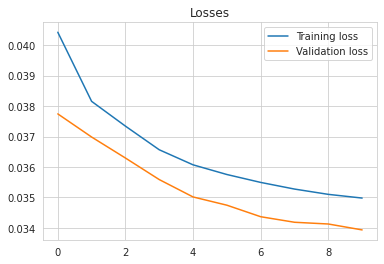

In [40]:
import torch.optim as optim
from datetime import datetime
input_dim = 7 #len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-6

# model_params = {'input_dim': input_dim,
#                 'hidden_dim' : hidden_dim,
#                 'layer_dim' : layer_dim,
#                 'output_dim' : output_dim,
#                 'dropout_prob' : dropout}

input_size = 7 #number of features
hidden_size = 5 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

model = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors.shape[1]) #our lstm class 

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [41]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds})
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, mm)

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'r2' : r2_score(df.value, df.prediction)}

result_metrics = calculate_metrics(df_result)
result_metrics

{'mae': 6828.9263, 'r2': 0.6229016443899855, 'rmse': 9300.013333323775}

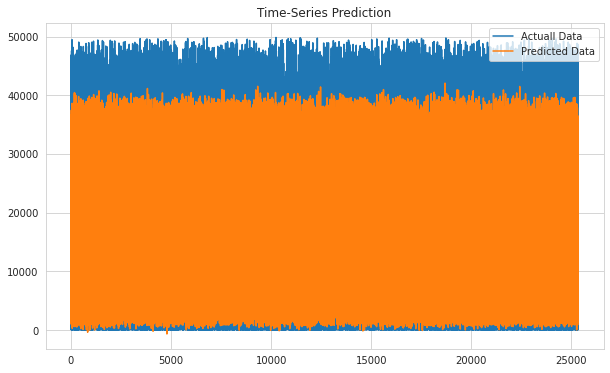

In [43]:
train_predict = model(X_test_tensors)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y_test

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
# plt.axvline(x=100000, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [44]:
import torch.optim as optim
from datetime import datetime
input_dim = 7 #len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-6

# model_params = {'input_dim': input_dim,
#                 'hidden_dim' : hidden_dim,
#                 'layer_dim' : layer_dim,
#                 'output_dim' : output_dim,
#                 'dropout_prob' : dropout}

input_size = 7 #number of features
hidden_size = 5 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

model = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors.shape[1]) #our lstm class 

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

KeyboardInterrupt: ignored

In [25]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds})
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, mm)

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'r2' : r2_score(df.value, df.prediction)}

result_metrics = calculate_metrics(df_result)
result_metrics

{'mae': 6897.116, 'r2': 0.6688233254715605, 'rmse': 9315.591661295593}

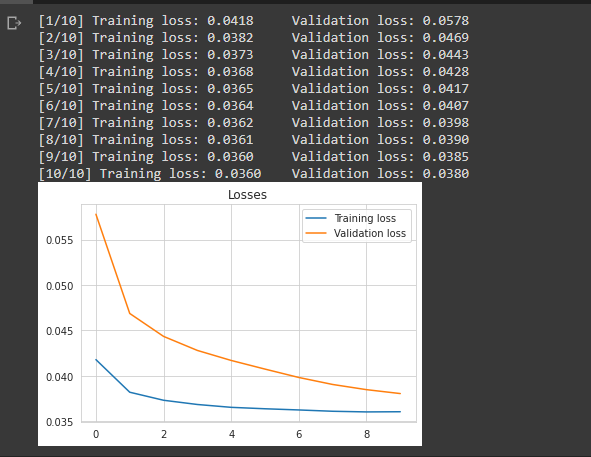

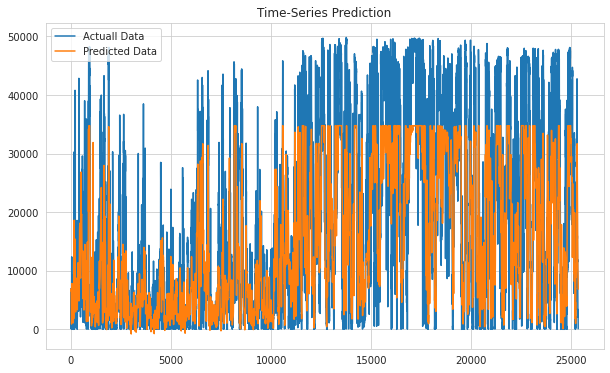

In [27]:
train_predict = model(X_test_tensors)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y_test

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
# plt.axvline(x=100000, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 